<a href="https://colab.research.google.com/github/patelruday/Fake_News_detection/blob/main/Fake_News_Detection_Analysis_LSTM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Information

Develop a Deep learning program to identify when an article might be fake news.


### Attributes
- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable

In [75]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [76]:
!pip install wordcloud


## Import Modules

In [111]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
%matplotlib inline

#warnings.filterwarnings('ignore')

## Loading the Dataset

In [78]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [79]:
df.shape

(20800, 5)

In [80]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [81]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


## Data Proprocessing

According to our task as fake news detection , id,title and author coulumns are not useful so we drop them.

In [83]:
# drop unnecessary columns
df = df.drop(columns=['id', 'title', 'author'], axis=1)

In [84]:
# drop null values
df = df.dropna(axis=0)

In [85]:
len(df)

20761

In [86]:
# remove special characters and punctuations

In [87]:
df['clean_news'] = df['text'].str.lower()
df['clean_news']

,clean_news
0,house dem aide: we didn’t even see comey’s let...
1,ever get the feeling your life circles the rou...
2,"why the truth might get you fired october 29, ..."
3,videos 15 civilians killed in single us airstr...
4,print \nan iranian woman has been sentenced to...
...,...
20795,rapper t. i. unloaded on black celebrities who...
20796,when the green bay packers lost to the washing...
20797,the macy’s of today grew from the union of sev...
20798,"nato, russia to hold parallel exercises in bal..."


In [88]:
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ')
df['clean_news']

,clean_news
0,house dem aide: we didn’t even see comey’s let...
1,ever get the feeling your life circles the rou...
2,"why the truth might get you fired october 29, ..."
3,videos 15 civilians killed in single us airstr...
4,print an iranian woman has been sentenced to s...
...,...
20795,rapper t. i. unloaded on black celebrities who...
20796,when the green bay packers lost to the washing...
20797,the macy’s of today grew from the union of sev...
20798,"nato, russia to hold parallel exercises in bal..."


In [89]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [90]:
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
df.head()

,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide: didn’t even see comey’s letter...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,"truth might get fired october 29, 2016 tension..."
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


In [91]:
df['label'].value_counts()

,count
label,
0,10387
1,10374


## Exploratory Data Analysis

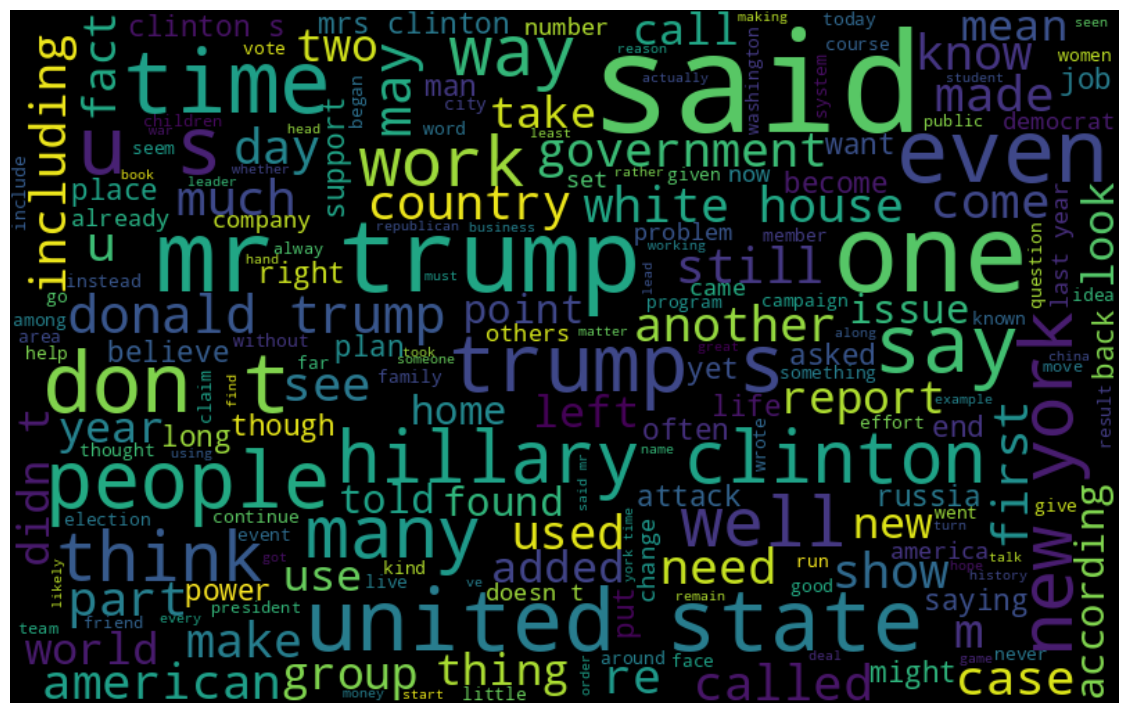

In [92]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_news']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

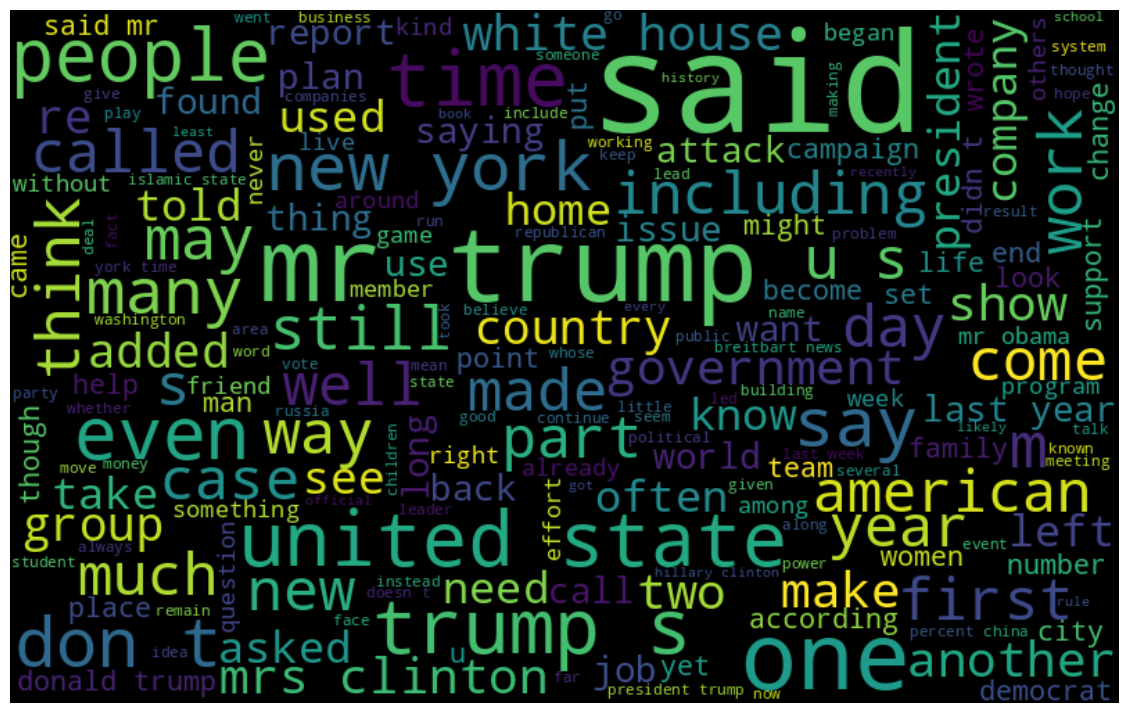

In [93]:
# visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

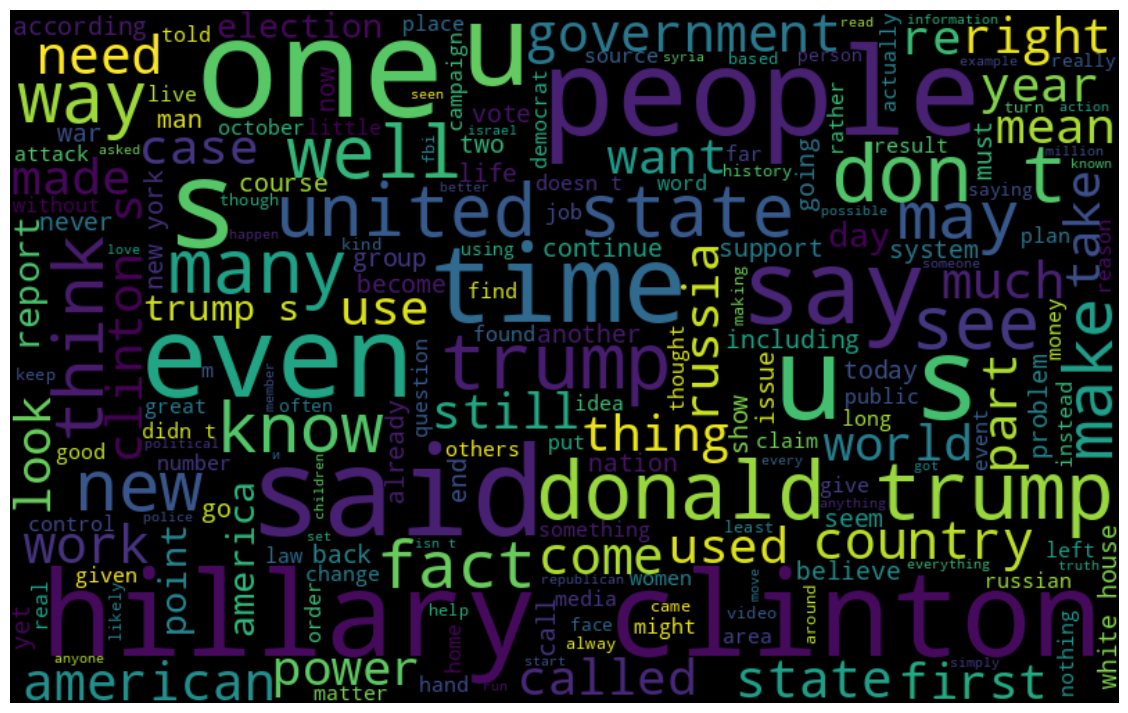

In [94]:
# visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Create Word Embeddings

In [95]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

239494

In [96]:
# padding data
sequences = tokenizer.texts_to_sequences(df['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [97]:
padded_seq.shape

(20761, 500)

In [98]:
# create embedding index
embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [99]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # check if the embedding_vector has the correct size
        if embedding_vector.shape[0] == 100:
            embedding_matrix[i] = embedding_vector
        else:
            # handle mismatched embedding size (e.g., skip or pad)
            print(f"Warning: Mismatched embedding size for word '{word}': {embedding_vector.shape}")

In [100]:
embedding_matrix[1]

array([ 0.13342001,  0.19998001, -0.25533   , -0.051146  ,  0.11102   ,
        0.31290999,  0.20461001, -0.16978   ,  0.23591   , -0.19870999,
        0.27361   , -0.44758999,  0.15266   ,  0.36144999,  0.042599  ,
       -0.375     ,  0.35876   ,  0.38881999, -0.71937001,  0.45868   ,
       -0.026418  , -0.28536001, -0.30691999, -0.27586001,  0.19926   ,
        0.36140999,  0.11371   , -0.34173   ,  0.44716999,  0.027599  ,
       -0.12358   ,  0.43586001, -0.043002  ,  0.019661  ,  0.0075122 ,
       -0.092998  , -0.14560001,  0.21397001,  0.043995  , -0.78390002,
       -0.082397  , -0.27105001, -0.29763001,  0.18043999, -0.18894   ,
       -0.75373   , -0.23617999,  0.019604  , -0.38022   , -0.10602   ,
       -0.031779  ,  0.37211999,  0.20428   ,  1.02499998, -0.24906   ,
       -2.09050012,  0.12701   ,  0.043019  ,  0.99423999,  0.025519  ,
       -0.12768   ,  0.68374002, -0.45173001, -0.36655   ,  1.12810004,
       -0.16283999,  0.18392999, -0.32929999,  0.73676997, -0.30

## Input Split

In [101]:
padded_seq[1]

array([   263,     33,   1664,     98,   5161,  29152,    455,   2398,
         2133,    400,    585,   1649,   5599,     34,     13,    851,
          195,    401,   2018,  18232,    860,  21158,   3122,   2786,
          692,    794,    274,   2102,   3296,  11420,    141,     43,
         2279,  92511,   3242,   3788,   3712,   3296,    857,    174,
         3592,     34,  10160,  58240,   3369,     20,    233,     23,
         3345,  21158,  10415,    618,     12,    526,   2537,   2552,
         8371,    512,    743,   1539,    668,    157,     16,  23486,
          955,  25165,    354,     10,    178,   3833,     60,  11867,
          931,   2822,     19,    890,   5150,    190,     53,   5617,
         2279,   4668,     46,    275,    857,    224,     15,      4,
         2267,     15,      1,   2279,  10160,     67,   8823,  11583,
       125498,  21595,   3905, 125499,  92512, 125500,   5696,  33536,
        28289,   8340,  19700,  75640,   4604,      4,    176,    278,
      

In [102]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_seq, df['label'], test_size=0.20, random_state=42, stratify=df['label'])

Model Building

In [103]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, weights=[embedding_matrix],output_dim=100, input_length=500,trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units=1, activation='sigmoid'))


In [104]:
model.build(input_shape=(None, 500))  # You can specify the batch size as None
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 500, 100)            │      23,949,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 500, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 500, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 500, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,116,221 (92.00 MB)

 Trainable params: 166,721 (651.25 KB)

 Non-trainable params: 23,949,500 (91.36 MB)

In [106]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


## Model Training

In [107]:
# train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.5751 - loss: 0.6712 - val_accuracy: 0.6222 - val_loss: 0.6564
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6313 - loss: 0.6433 - val_accuracy: 0.5442 - val_loss: 0.6771
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6009 - loss: 0.6550 - val_accuracy: 0.6506 - val_loss: 0.6259
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.6721 - loss: 0.6049 - val_accuracy: 0.7652 - val_loss: 0.5591
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6256 - loss: 0.6574 - val_accuracy: 0.5285 - val_loss: 0.6653
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.5995 - loss: 0.6580 - val_accuracy: 0.6239 - val_loss: 0.6356
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6014 - loss: 0.6515 - val_accuracy: 0.4996 - val_loss: 0.7096
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.5676 - loss: 0.6682 - val_accuracy: 0.6275

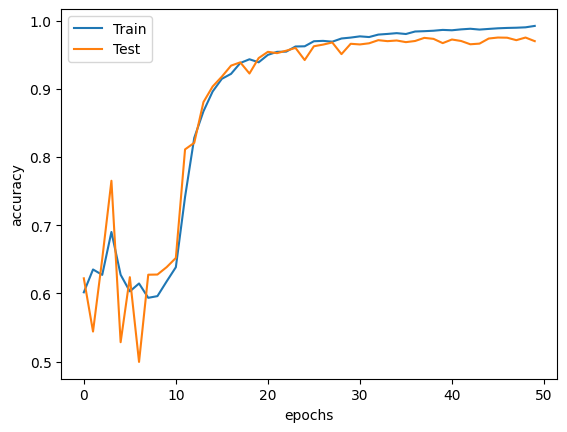

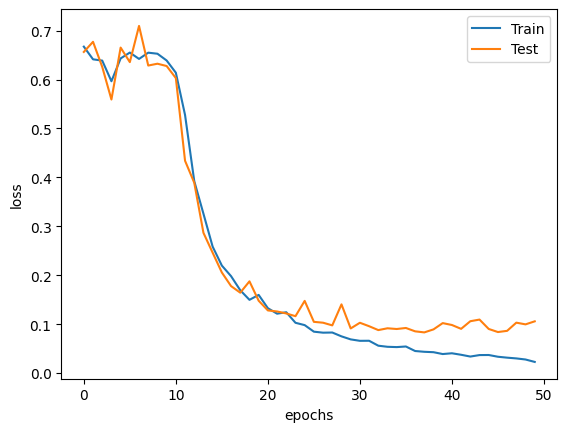

In [109]:
# visualize the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [112]:
y_pred=model.predict(x_test)

130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


In [113]:
confusion_matrix(y_test,y_pred.round())

array([[2046,   32],
       [  93, 1982]])

In [114]:
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2078
           1       0.98      0.96      0.97      2075

    accuracy                           0.97      4153
   macro avg       0.97      0.97      0.97      4153
weighted avg       0.97      0.97      0.97      4153

